# Logistic Regression for Multiple Products

In [1]:
import math
import operator
import itertools
import numpy as np
import sklearn.linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import time

%matplotlib inline

## Konstanten

In [2]:
# General parameters
min_price = 1
max_price = 20
price_step = 0.5
product_range = range(2)
prices_ranges = [np.arange(min_price, max_price + price_step, price_step) for i in product_range]
competitors_count = 5
competitors_count_range = range(competitors_count)

# Regression parameters
observations_count = 1000
observations_count_range = range(observations_count)

# Optimization parameters
delta = 0.99
holding_cost_rate = [0.01, 0.01]
init_inventory = [3, 3]
optimization_steps = 10
simulation_length = 500

## Simulierte Daten

In [3]:
def generate_prices(prices_range, count):
    return np.random.choice(prices_range, count)

def generate_competitor_prices(prices_range):
    return np.array([generate_prices(prices_range, observations_count) for j in competitors_count_range])
    
def calculate_ranks(prices, competitor_prices):
    return [1 + len([1 for j in competitors_count_range if competitor_prices[j, k] < prices[k]])
            for k in observations_count_range]

def boost_price(boost_factor, price):
    return min(max_price, round((1 + boost_factor) * price, 1))

price_index = {}
for price in prices_ranges[0]:
    price_index[price] = int(price / price_step - min_price / price_step)

In [4]:
prices = np.array([generate_prices(prices_ranges[i], observations_count) for i in product_range]) 
competitor_prices = np.array([generate_competitor_prices(prices_ranges[i]) for i in product_range])

"""
# Boost prices for product A
for k in observations_count_range:
    prices[0, k] = boost_price(0.4, prices[0, k])
    for j in competitors_count_range:
        competitor_prices[0, j, k] = boost_price(0.4, competitor_prices[0, j, k])
"""

ranks = np.array([calculate_ranks(prices[i], competitor_prices[i]) for i in product_range])

In [5]:
def calculate_sale_probs_A(prices, ranks):
    max_prob = lambda i: 1 - ((0.3 * ranks[0, i]) / (competitors_count + 1)) - \
                         0.05 * prices[0, i] + \
                         (-0.0125 * (prices[0, i] - prices[1, i]) + 0.25)
            
    return [max(0, round(np.random.uniform(0, max_prob(i)))) for i in observations_count_range]

def calculate_sale_probs_B(prices, ranks):
    max_prob = lambda i: 1 - ((0.3 * ranks[1, i]) / (competitors_count + 1)) - \
                         0.05 * prices[1, i] + \
                         (0.0125 * (prices[0, i] - prices[1, i]) + 0.25)
            
    return [max(0, round(np.random.uniform(0, max_prob(i)))) for i in observations_count_range]

In [6]:
sale_probs = [calculate_sale_probs_A(prices, ranks),
              calculate_sale_probs_B(prices, ranks)]

## Regression

In [7]:
def get_all_competitor_prices(observation):
    for i in product_range:
            for j in competitors_count_range:
                yield competitor_prices[i, j, observation]
                
def get_explanatory_vars(product, ranks, competitor_prices):
    explanatory_1 = [1] * observations_count
    explanatory_2 = [ranks[product, k] for k in observations_count_range]
    explanatory_3 = [prices[product, k] - min(get_all_competitor_prices(k)) for k in observations_count_range]
    explanatory_4 = [prices[product, k] - min(prices[i, k] for i in product_range) for k in observations_count_range]
    explanatory_5 = list(map(lambda x: math.pow(x, 2),explanatory_4))
    
    return np.matrix([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

In [8]:
explanatory_vars = [get_explanatory_vars(i, ranks, competitor_prices) for i in product_range]
logits = [sm.Logit(sale_probs[i], explanatory_vars[i].transpose()) for i in product_range]
results = [logits[i].fit() for i in product_range]
beta = [results[i].params for i in product_range]
beta

Optimization terminated successfully.
         Current function value: 0.330825
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.352645
         Iterations 11


[array([ 0.96526326, -0.46042041, -0.15358806,  0.35381644, -0.12981929]),
 array([ 0.99682552, -0.53080201, -0.11925142, -0.10410771, -0.02443114])]

In [9]:
[results[i].aic for i in product_range]

[671.6505619712882, 715.29048639730706]

## Optimierung

In [10]:
#beta = [[ 0.6, -2, -0.3, -0.1 ],[ -10 , -0.25  , -1, -0.15]]

# Generate competitor prices for new, specific situation
competitor_prices = np.array([generate_prices(prices_ranges[i], competitors_count) for i in product_range])

#competitor_prices = [[25,30],[25,30]]

In [11]:
competitor_prices

array([[  1.5,  14.5,   2.5,   5.5,   6. ],
       [ 16.5,   4.5,   2.5,  12. ,  10. ]])

### Recreate explanatory vars depending on price combinations

In [12]:
min_competitor_prices = min_price
def calculate_min_competitor_prices():
    global min_competitor_prices
    min_competitor_prices = np.min(competitor_prices) 

def get_explanatory_vars_replica_A(competitor_prices):
    explanatory_1 = np.array([[1] * len(prices_ranges[0])] * len(prices_ranges[1]))
    explanatory_2 = np.array([[1 + len([1 for j in competitors_count_range if competitor_prices[0, j] < price_A]) 
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_3 = np.array([[price_A - min_competitor_prices
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_4 = np.array([[price_A - price_B
                                for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_5 = np.array([[math.pow(explanatory_4[price_index[price_A], price_index[price_B]], 2) 
                                for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    
    return np.array([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])

def get_explanatory_vars_replica_B(competitor_prices):
    explanatory_1 = np.array([[1] * len(prices_ranges[0])] * len(prices_ranges[1]))
    explanatory_2 = np.array([[1 + len([1 for j in competitors_count_range if competitor_prices[1, j] < price_B]) 
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_3 = np.array([[price_B - min_competitor_prices
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_4 = np.array([[price_B - price_A
                                for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_5 = np.array([[math.pow(explanatory_4[price_index[price_A], price_index[price_B]], 2) 
                                for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    
    return np.array([explanatory_1, explanatory_2, explanatory_3, explanatory_4, explanatory_5])


def get_explanatory_vars_replica_A_sim(competitor_prices, explanatory_vars_A):
    explanatory_2 = np.array([[1 + len([1 for j in competitors_count_range if competitor_prices[0, j] < price_A]) 
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_3 = np.array([[price_A - min_competitor_prices 
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])

    return np.array([explanatory_vars_A[0], explanatory_2, explanatory_3, explanatory_vars_A[3], explanatory_vars_A[4]])

def get_explanatory_vars_replica_B_sim(competitor_prices, explanatory_vars_B):
    explanatory_2 = np.array([[1 + len([1 for j in competitors_count_range if competitor_prices[1, j] < price_B]) 
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])
    explanatory_3 = np.array([[price_B - min_competitor_prices
                               for price_B in prices_ranges[1]] for price_A in prices_ranges[0]])

    return np.array([explanatory_vars_B[0], explanatory_2, explanatory_3, explanatory_vars_B[3], explanatory_vars_B[4]])

In [13]:
calculate_min_competitor_prices()
explanatory_vars = [get_explanatory_vars_replica_A(competitor_prices),
                    get_explanatory_vars_replica_B(competitor_prices)]

### Calculate sale probabilities with betas

In [14]:
def calculate_sale_probs(beta, explanatory_vars):
    sale_probs = np.empty(shape=(2, 2, len(prices_ranges[0]), len(prices_ranges[1])))
    for i in product_range:
        for price_A in prices_ranges[0]:
            for price_B in prices_ranges[1]:
                L = sum([beta[i][l] * explanatory_vars[i][l, price_index[price_A], price_index[price_B]] for l in range(len(beta[i]))])
                p = np.exp(L) / (1 + np.exp(L))
                sale_probs[0, i, price_index[price_A], price_index[price_B]] = 1 - p
                sale_probs[1, i, price_index[price_A], price_index[price_B]] = p
    return sale_probs

In [15]:
sale_probs = calculate_sale_probs(beta, explanatory_vars)

### Calculate optimal prices using Bellman

In [16]:
def get_event_combinations(n):
        possibile_events = [[0] if n[i] == 0 else [0,1] for i in product_range]
        return itertools.product(*possibile_events)

def bellman(n, sale_probs, values, step):
    prob = lambda i, e, prices: sale_probs[e[i], i, price_index[prices[0]], price_index[prices[1]]]
    todays_profit = lambda e, prices: sum(min(n[i], e[i]) * prices[i] - n[i] * holding_cost_rate[i] for i in product_range)
    disc_exp_fut_profits = lambda e: delta * values[step + 1, max(0, n[0] - e[0]), max(0, n[1] - e[1])]
    
    bellman_results = {}
    for prices in itertools.product(prices_ranges[0], prices_ranges[1]):
        result = sum(prob(0, e, prices) * prob(1, e, prices) * (todays_profit(e, prices) + disc_exp_fut_profits(e)) 
                     for e in get_event_combinations(n))
        bellman_results[prices] = result
    
    return max(bellman_results.items(), key=operator.itemgetter(1))

In [17]:
def bellman_new(sale_probs):
    bellman_results = np.empty(shape=(len(prices_ranges[0]),len(prices_ranges[1])))
    for price_A in prices_ranges[0]:
        for price_B in prices_ranges[1]:
            prices = [price_A, price_B]
            result = 1/(1-delta) * sum(sum(sale_probs[k, j, price_index[prices[0]], price_index[prices[1]]] * k * prices[j] for k in product_range) for j in product_range)
            bellman_results[price_index[price_A]][price_index[price_B]] = result
    argmax = np.unravel_index(bellman_results.argmax(), bellman_results.shape)
    opt_price_A = prices_ranges[0][argmax[0]]
    opt_price_B = prices_ranges[1][argmax[1]]
    opt_prices = [opt_price_A, opt_price_B]
        
    return opt_prices, bellman_results

In [18]:
opt_prices, bellman_results = bellman_new(sale_probs)
print(opt_prices)
print(bellman_results[price_index[opt_prices[0]]][price_index[opt_prices[1]]])

[5.5, 4.5]
356.569626494


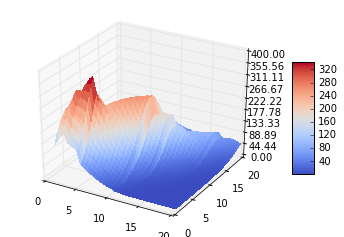

In [19]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
x = prices_ranges[0]
y = prices_ranges[1]
X,Y = np.meshgrid(x,y)
Z = bellman_results

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Simulation

In [20]:
# Competitor prices over the time period
competitor_prices_time = np.zeros(shape=(simulation_length, 2, competitors_count))
for i in product_range:
    for j in competitors_count_range:
        competitor_prices_time[0, i, j] = competitor_prices[0, j]
        
# Own prices over the time period
prices_time = np.zeros(shape=(simulation_length, 2))
prices_time[0, 0] = opt_prices[0]
prices_time[0, 1] = opt_prices[1]

# count number of sales
product_sales = np.zeros(shape=(simulation_length, 2))
profit_time = np.zeros(shape=(simulation_length, 2))
expected_profit = np.zeros(shape=(simulation_length))

# Naive Prices
naive_prices_time = np.zeros(shape=(simulation_length, 2))
naive_prices_time[0, 0] = max(min_price, np.min(competitor_prices_time[0,0]) - price_step)
naive_prices_time[0, 1] = max(min_price, np.sort(competitor_prices_time[0,1])[1] - price_step)
naive_product_sales = np.zeros(shape=(simulation_length, 2))
naive_profit_time = np.zeros(shape=(simulation_length, 2))
naive_expected_profit = np.zeros(shape=(simulation_length))

In [21]:
count = 0
time_0 = time.time()
for step in range(1, simulation_length):
    for i in product_range:
        # own sales for previous period
        sale_prob = sale_probs[i, 1, price_index[prices_time[step - 1, 0]], price_index[prices_time[step - 1,1]]]
        if np.random.uniform(0, 1) < sale_prob:
            product_sales[step, i] = product_sales[step-1, i] + 1
            profit_time[step, i] = profit_time[step-1, i] + prices_time[step-1, i]
        else:
            product_sales[step, i] = product_sales[step-1, i]
            profit_time[step, i] = profit_time[step-1, i]
        expected_profit[step] = bellman_results[price_index[prices_time[step - 1, 0]], price_index[prices_time[step - 1, 1]]]
        naive_expected_profit[step] = bellman_results[price_index[naive_prices_time[step - 1, 0]], price_index[naive_prices_time[step - 1, 1]]]
        
        # naive sales for previous period    
        naive_sale_prob = sale_probs[i, 1, price_index[naive_prices_time[step - 1, 0]], price_index[naive_prices_time[step - 1,1]]]
        if np.random.uniform(0, 1) < naive_sale_prob:
            naive_product_sales[step, i] = naive_product_sales[step-1, i] + 1
            naive_profit_time[step, i] = naive_profit_time[step-1, i] + naive_prices_time[step-1, i]
        else:
            naive_product_sales[step, i] = naive_product_sales[step-1, i]
            naive_profit_time[step, i] = naive_profit_time[step-1, i]
    
        # vary competitor prices
        calculate_bellman_again = False
        for j in competitors_count_range:
            if np.random.uniform(0, 1) < 0.1:
                boost = np.random.uniform(0.8, 1.2)
                competitor_prices_time[step, i, j] = min(max_price, round(competitor_prices_time[step - 1, i, j] * boost, 1))
                calculate_bellman_again = True
            else:
                competitor_prices_time[step, i, j] = competitor_prices_time[step-1, i, j]
                
    # adjust own prices for next period        
    if calculate_bellman_again:
        count = count + 1
        calculate_min_competitor_prices()
        explanatory_vars = [get_explanatory_vars_replica_A_sim(competitor_prices_time[step], explanatory_vars[0]),
                            get_explanatory_vars_replica_B_sim(competitor_prices_time[step], explanatory_vars[1])]
        sale_probs = calculate_sale_probs(beta, explanatory_vars)
        opt_prices, bellman_results = bellman_new(sale_probs)
        prices_time[step, 0] = opt_prices[0]
        prices_time[step, 1] = opt_prices[1]
    else:
        prices_time[step, 0] = prices_time[step-1, 0]
        prices_time[step, 1] = prices_time[step-1, 1]
            
    # adjust naive prices for next period
    naive_prices_time[step, 0] = max(min_price, round((np.min(competitor_prices_time[step,0]) - price_step) * 2) / 2)
    naive_prices_time[step, 1] = max(min_price, round((np.sort(competitor_prices_time[step,1])[1] - price_step) * 2) / 2)
    
print(time.time()-time_0)

14.5520000458


In [22]:
count

194

### Plots

In [23]:
# own strategy
swap_prices_time = np.swapaxes(prices_time, 0,1)
swap_product_sales = np.swapaxes(product_sales, 0,1)
swap_profit_time = np.swapaxes(profit_time, 0,1)

# naive strategy
swap_naive_prices_time = np.swapaxes(naive_prices_time, 0,1)
swap_naive_product_sales = np.swapaxes(naive_product_sales, 0,1)
swap_naive_profit_time = np.swapaxes(naive_profit_time, 0,1)

swap_competitor_prices_time = np.swapaxes(competitor_prices_time, 0,2)

#### Prices over time

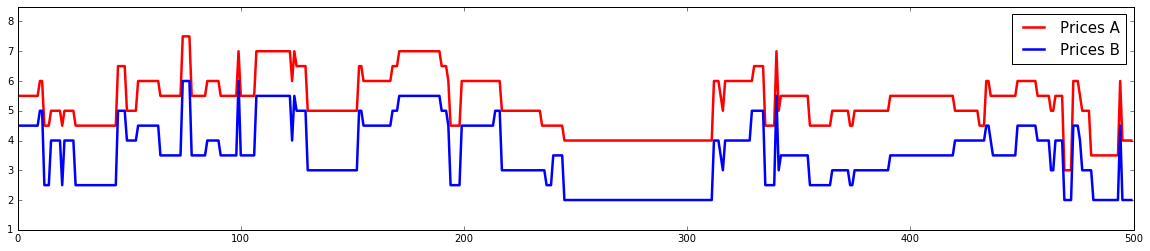

In [24]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), swap_prices_time[0], label='Prices A', color="red", linewidth=2.5)
plt.plot(range(simulation_length), swap_prices_time[1], label='Prices B', color="blue", linewidth=2.5)
plt.axis([0, simulation_length, min(min(swap_prices_time[0]), min(swap_prices_time[1])) - 1, max(max(swap_prices_time[0]), max(swap_prices_time[1])) + 1])
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

#### Sales over time

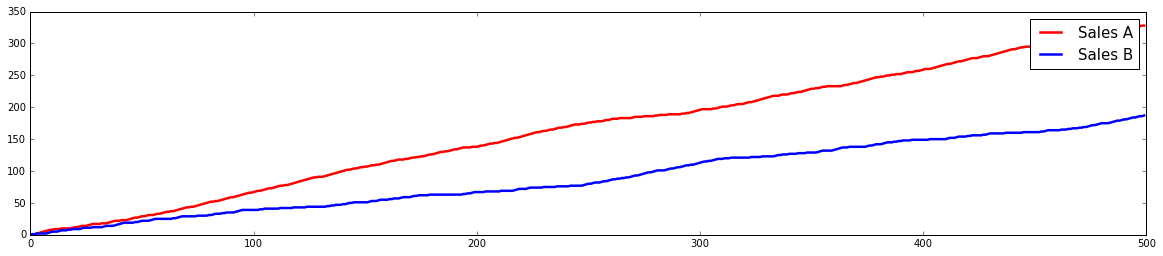

In [25]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), swap_product_sales[0], label='Sales A', color="red", linewidth=2.5)
plt.plot(range(simulation_length), swap_product_sales[1], label='Sales B', color="blue", linewidth=2.5)
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

#### Product 1: Own Prices and Competitor Prices

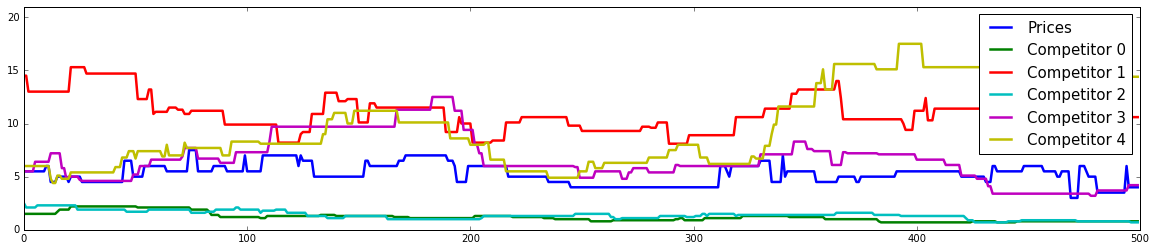

In [26]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), swap_prices_time[0], label='Prices', linewidth=2.5)
for competitor in competitors_count_range:
    plt.plot(range(simulation_length), swap_competitor_prices_time[competitor][0], label='Competitor '+str(competitor), linewidth=2.5)
plt.axis([0, simulation_length, min_price - 1, max_price + 1])
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

#### Product 2: Own Prices and Competitor Prices

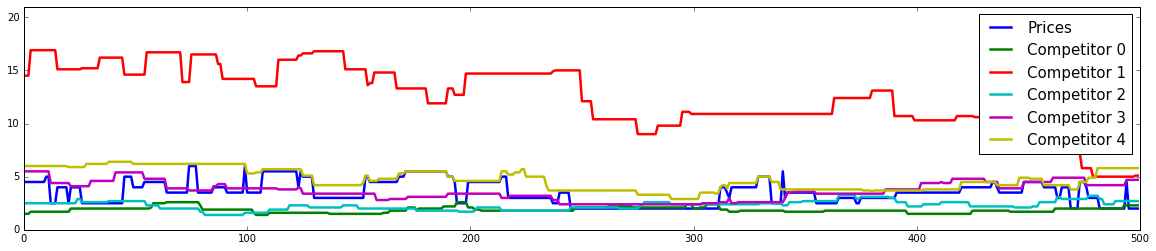

In [27]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), swap_prices_time[1], label='Prices', linewidth=2.5)
for competitor in competitors_count_range:
    plt.plot(range(simulation_length), swap_competitor_prices_time[competitor][1], label='Competitor '+str(competitor), linewidth=2.5)

plt.axis([0, simulation_length, min_price - 1, max_price + 1])
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

#### Profit

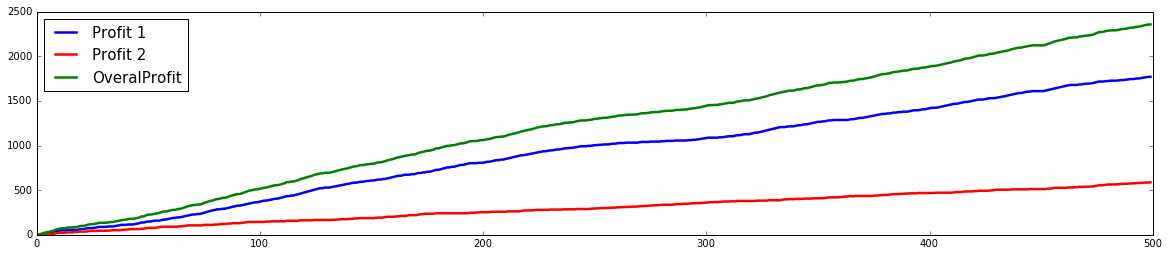

In [28]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), swap_profit_time[0], label='Profit 1', color="blue", linewidth=2.5)
plt.plot(range(simulation_length), swap_profit_time[1], label='Profit 2', color="red", linewidth=2.5)
plt.plot(range(simulation_length), np.sum(profit_time,1), label='OveralProfit', color="green", linewidth=2.5)
plt.legend(loc='upper left', prop={'size': 15})
plt.show()

#### Compare to Naive Strategy: Profit

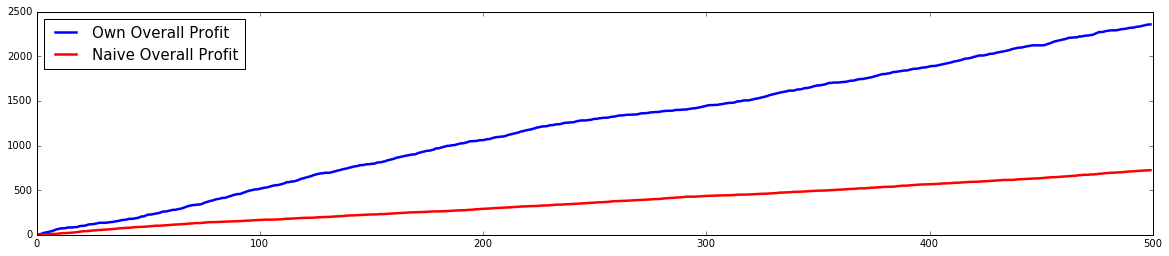

In [29]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), np.sum(profit_time,1), label='Own Overall Profit', color="blue", linewidth=2.5)
plt.plot(range(simulation_length), np.sum(naive_profit_time,1), label='Naive Overall Profit', color="red", linewidth=2.5)
plt.legend(loc='upper left', prop={'size': 15})
plt.show()

#### Compare to Naive Strategy: Expected Profit

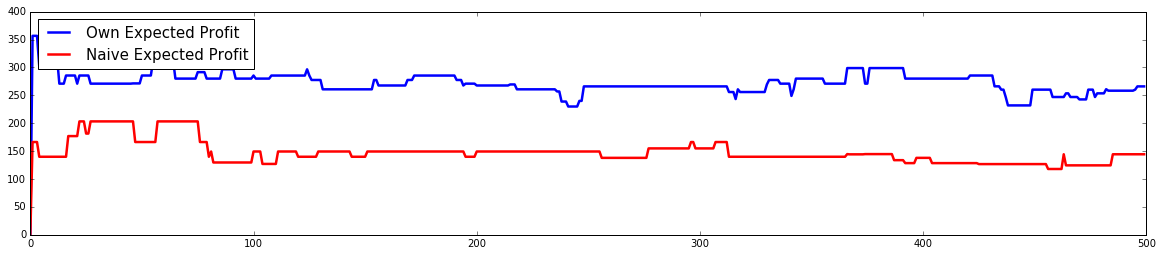

In [30]:
plt.figure(figsize=(20, 4))
plt.plot(range(simulation_length), expected_profit, label='Own Expected Profit', color="blue", linewidth=2.5)
plt.plot(range(simulation_length), naive_expected_profit, label='Naive Expected Profit', color="red", linewidth=2.5)
plt.legend(loc='upper left', prop={'size': 15})
plt.show()